In [3]:
from datasets import load_dataset

dataset = load_dataset('food101')

In [4]:
labels = dataset['train'].features['label'].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
id2label[2]

'baklava'

In [5]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(
    'google/vit-base-patch16-224-in21k')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean,
                      std=image_processor.image_std)
train_transforms = Compose([
    RandomResizedCrop(image_processor.size['height']),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])
val_transforms = Compose([
    Resize(image_processor.size['height']),
    CenterCrop(image_processor.size['height']),
    ToTensor(),
    normalize,
])


def preprocess_train(example_batch):
    example_batch["pixel_values"] = [train_transforms(
        image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transforms(
        image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [8]:
train_dataset = dataset['train']
val_dataset = dataset['validation']
train_dataset.set_transform(preprocess_train)
val_dataset.set_transform(preprocess_val)

In [9]:
import torch


def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values']
                               for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {'pixel_values': pixel_values, 'labels': labels}

In [11]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k', label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(r=16, lora_alpha=16, target_modules=[
                    'query', 'value'], lora_dropout=0.1, bias='none',
                    modules_to_save=['classifier'])
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 667,493 || all params: 86,543,818 || trainable%: 0.7713


In [13]:
from transformers import TrainingArguments, Trainer

account = 'rodmosc'
peft_model_id = f'{account}/google/vit-base-patch16-224-in21k-lora'
batch_size = 128
args = TrainingArguments(
    peft_model_id,
    remove_unused_columns=False,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    label_names=['labels']
)

In [14]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=image_processor,
    data_collator=collate_fn
)
trainer.train()

/Users/oscar/Desktop/Projects/notebooks/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.816700,0.465673
2,0.707800,0.407023
3,0.669700,0.371670
4,0.572600,0.346935
5,0.531900,0.334666


/Users/oscar/Desktop/Projects/notebooks/venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/Users/oscar/Desktop/Projects/notebooks/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/oscar/Desktop/Projects/notebooks/venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 29c427c1-a85c-4703-8051-fd47441a8a04)')' thrown while requesting HEAD https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/config.json
Retrying in 1s [Retry 1/5].
/Users/oscar/Desktop/Projects/notebooks/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 

TrainOutput(global_step=740, training_loss=0.7195719557839471, metrics={'train_runtime': 105098.1645, 'train_samples_per_second': 3.604, 'train_steps_per_second': 0.007, 'total_flos': 2.960446615709184e+19, 'train_loss': 0.7195719557839471, 'epoch': 5.0})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [17]:
model.push_to_hub('rodmosc/vit-base-patch16-224-in21k-lora')

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/rodmosc/vit-base-patch16-224-in21k-lora/commit/ddc764842bc44a5aea52f05521dc2aa9d9220574', commit_message='Upload model', commit_description='', oid='ddc764842bc44a5aea52f05521dc2aa9d9220574', pr_url=None, repo_url=RepoUrl('https://huggingface.co/rodmosc/vit-base-patch16-224-in21k-lora', endpoint='https://huggingface.co', repo_type='model', repo_id='rodmosc/vit-base-patch16-224-in21k-lora'), pr_revision=None, pr_num=None)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

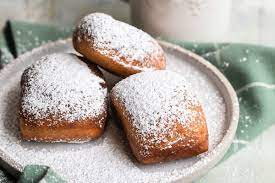

In [19]:
from peft import PeftConfig, PeftModel
from transformers import AutoImageProcessor
from PIL import Image
import requests

model_id = 'rodmosc/vit-base-patch16-224-in21k-lora'
config = PeftConfig.from_pretrained(model_id)
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)
model = PeftModel.from_pretrained(model, model_id)
url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/beignets.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [20]:
encoding = image_processor(image.convert('RGB'), return_tensors='pt')

In [ ]:
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print(
    f'predicted class: {predicted_class_idx}, {model.config.id2label[predicted_class_idx]}')

predicted class: 6, beignets
